<a href="https://colab.research.google.com/github/GarlicSoup/horse_racing_prediction/blob/main/advanced_pred_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Optional) Preparation steps to enable LightGBM with gpu in CoLab

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

In [3]:
%cd /content/LightGBM/python-package

/content/LightGBM/python-package


In [ ]:
!sudo python setup.py install --precompile

In [ ]:
! pip install -U catboost
! pip install -U hyperopt
! pip install -U scikit-learn
! pip install -U imblearn
! pip install -U six

In [ ]:
%pwd
%cd ..
%cd ..
%pwd

# Mounting Google Drive locally
Mount the Google Driver into the Google Colab Driver.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preperation

## Import all useful packages.

In [8]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import json
import os
from os.path import dirname, abspath
from sklearn.metrics import f1_score
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
import catboost 
#from imblearn.over_sampling import SMOTE, ADASYN
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.utils import class_weight
import numpy as np
from sklearn.ensemble import VotingClassifier

## Import data

In [9]:
current_dir_path = "drive/MyDrive/DataScience/horse_pred/src/models/"
parent_dir_path = dirname(dirname(current_dir_path))
print(parent_dir_path)
df_train = pd.read_csv(parent_dir_path +"/extracted_feature/training.csv")
df_test = pd.read_csv(parent_dir_path +"/extracted_feature/testing.csv")

drive/MyDrive/DataScience/horse_pred/src


## Select features based upon those algorithm and personal analysis

In [10]:
print("Select useful data...")
with open(parent_dir_path + '/models/useful_features.json') as f:
  useful_features = json.load(f)
# Remove SexCD attribute
useful_features.pop("SexCD")

X_train = df_train[useful_features]
y_train_top3 = df_train["horse_rank_top3"]
X_test = df_test[useful_features]
y_test_top3 = df_test["horse_rank_top3"]
print("Finished selecting!\n")


Select useful data...
Finished selecting!



# Normalization

Standard Normalization

In [11]:
print("Normalization...")
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)
print("Finished normalization!\n")

Normalization...
Finished normalization!



# Useful functions: 

## Accuracy calculation and pickling models

- def calc_accuracy: calculate and show accuracy

- def create_model_pickle: create a pickle file that contains the model architecture

In [12]:
def calc_accuracy(groundtruth, prediction):
    # input: groundtruth and prediction results
    # output: f1_score and comfussion matrix
    f1_score_model = f1_score(groundtruth, prediction, average="weighted")
    print(f"F1 score: {f1_score_model:0.5f}")
    cm = confusion_matrix(groundtruth, prediction)
    true_pos_win_rate = cm[1,1]/(cm[1,0]+cm[1,1])
    print(f"correct_pred_top3/total_actual_top3: {true_pos_win_rate:0.5f}")
    return f1_score_model, true_pos_win_rate

def create_model_pickle(model, filename):
    print(f"Pickling the model into the file {filename}")
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print("Finished pickling the model")


## Function to plot confusion matrix

plot_confusion_matrix(predictions, groundtruth, class_names,normalize=True)

- Input: prediction: 
-- results from model, 
-- groundtruth: true outcomes
-- class_names: labels of each class
-- normalize: if set to true, normalize the results of the confusion matrix

- Output: plot the confusion matrix

In [13]:
def plot_confusion_matrix(predictions, 
                          groundtruth, 
                          class_names,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(groundtruth, predictions)
    
                          
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')
    title='Confusion matrix'
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Ground Truth label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid(False)
    print("correct_pred_top3/total_actual_top3: ", cm[1,1]/(cm[1,0]+cm[1,1]))
    plt.show()

# Prediction

In [14]:
# a dictionary for keeping all scores of the classifiers
f1_scores = {'train':{'logis_reg': 0, 'randomForest': 0, 'catboost': 0, 'lightGBM': 0, 'EN_HARD': 0, 'EN_SOFT': 0},
             'test':{'logis_reg': 0, 'randomForest': 0, 'catboost': 0, 'lightGBM': 0, 'EN_HARD': 0, 'EN_SOFT': 0}}
true_pos_wining_rates = {'train':{'logis_reg': 0, 'randomForest': 0, 'catboost': 0, 'lightGBM': 0, 'EN_HARD': 0, 'EN_SOFT': 0},
                            'test':{'logis_reg': 0, 'randomForest': 0, 'catboost': 0, 'lightGBM': 0, 'EN_HARD': 0, 'EN_SOFT': 0}}

## CatBoost

In [15]:
# *** CatBoost ***
print("Catboost...")
# Bayesian Optimization for tuning hyperparameters
print("Bayesian Optimization for tuning hyperparameters")
iterations = {0: 100, 1: 250, 2: 450, 3: 700, 4: 1000, 5: 2000}
catboost_space = {
    "iterations": hp.choice("iterations", iterations.values()),
    "l2_leaf_reg": hp.randint("l2_leaf_reg", 1000),
    "depth": hp.quniform("depth", 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.3),
    'bagging_temperature': hp.uniform('bagging_temperature', 1, 10)
}

def catboost_objective(params):
    model = catboost.CatBoostClassifier(**params, 
                                        eval_metric="AUC",
                                        class_weights=[1, 4],
                                        border_count=254,
                                        early_stopping_rounds=250,
                                        task_type="GPU",
                                        silent=True)
    acc = cross_val_score(model, X_train_std, y_train_top3, cv = 4, scoring='roc_auc').mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -acc, 'status': STATUS_OK }

t_tuning = time.time()
catboost_trials = Trials()
catboost_best_hyperparams = fmin(fn= catboost_objective,
                space= catboost_space,
                algo= tpe.suggest,
                max_evals = 100,
                trials= catboost_trials)
print(f"elapse time of tuning hyperparameter process: {time.time()-t_tuning} sec")

catboost_best_hyperparams['iterations']= iterations[catboost_best_hyperparams['iterations']]

catboost_best_hyperparams['class_weights'] = [1, 4]
catboost_best_hyperparams['silent'] = True
catboost_best_hyperparams['eval_metric'] = "AUC"
catboost_best_hyperparams['early_stopping_rounds'] = 250
catboost_best_hyperparams['task_type'] = "GPU"
print("best hyperparameters for Random Forest: ", catboost_best_hyperparams)

# Create json file that record best parameter of the model
with open('catboost_best_hyperparams.json', 'w') as fp:
    json.dump(catboost_best_hyperparams, fp)

Catboost...
Bayesian Optimization for tuning hyperparameters
100%|██████████| 100/100 [1:29:13<00:00, 53.54s/trial, best loss: -0.8568038798486344]
elapse time of tuning hyperparameter process: 5353.612135887146 sec
best hyperparameters for Random Forest:  {'bagging_temperature': 1.0027979773243854, 'depth': 5.0, 'iterations': 1000, 'l2_leaf_reg': 954, 'learning_rate': 0.08412342023364658, 'class_weights': [1, 4], 'silent': True, 'eval_metric': 'AUC', 'early_stopping_rounds': 250, 'task_type': 'GPU'}


In [16]:
catboost_model = catboost.CatBoostClassifier(iterations=catboost_best_hyperparams['iterations'], 
                          l2_leaf_reg=catboost_best_hyperparams['l2_leaf_reg'], 
                          depth=catboost_best_hyperparams['depth'],
                          learning_rate=catboost_best_hyperparams['learning_rate'],
                          bagging_temperature=catboost_best_hyperparams['bagging_temperature'],
                          class_weights=[1, 4],
                          border_count=254,
                          silent=True, 
                          eval_metric="AUC",
                          early_stopping_rounds=250,
                          task_type="GPU")

t0 = time.time()
catboost_model.fit(X_train_std,y_train_top3)
print(f"Training time for top3 CatBoost classifier: {time.time() - t0} sec")

# Prediction on training dataset
catboost_predict_top3_train = catboost_model.predict(X_train_std)
# Round the float number
catboost_predict_top3_train = catboost_predict_top3_train.round(0)
#converting from float to integer
catboost_predict_top3_train = catboost_predict_top3_train.astype(int)

# Prediction on testing dataset
catboost_predict_top3_test = catboost_model.predict(X_test_std)
# Round the float number
catboost_predict_top3_test = catboost_predict_top3_test.round(0)
#converting from float to integer
catboost_predict_top3_test = catboost_predict_top3_test.astype(int)

# Calculate accuracy
f1_score_train, true_pos_win_rate_train = calc_accuracy(y_train_top3, catboost_predict_top3_train)
f1_score_test, true_pos_win_rate_test = calc_accuracy(y_test_top3, catboost_predict_top3_test)

# Append values to accuracy dictionary
f1_scores["train"]["catboost"] = round(f1_score_train, 4)
true_pos_wining_rates["train"]["catboost"] = round(true_pos_win_rate_train, 4)
f1_scores["test"]["catboost"] = round(f1_score_test, 4)
true_pos_wining_rates["test"]["catboost"] = round(true_pos_win_rate_test, 4)

# Create a pickle file that contains the model
create_model_pickle(catboost_model, 'catboost.pkl')
print("CatBoost Done!\n")

Training time for top3 CatBoost classifier: 14.280487537384033 sec
F1 score: 0.76515
correct_pred_top3/total_actual_top3: 0.81419
F1 score: 0.66799
correct_pred_top3/total_actual_top3: 0.58305
Pickling the model into the file catboost.pkl
Finished pickling the model
CatBoost Done!



correct_pred_top3/total_actual_top3:  0.5830469644902635


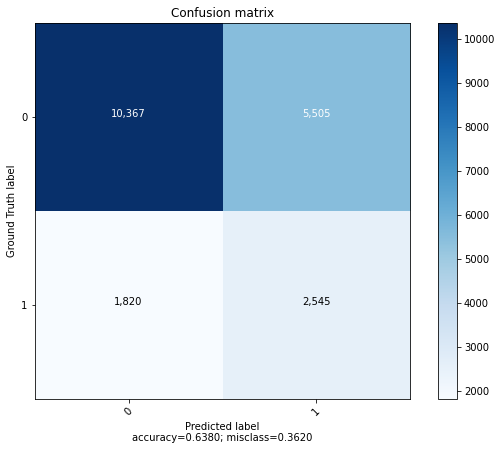

In [17]:
class_name = [0, 1]
plot_confusion_matrix(catboost_predict_top3_test, y_test_top3, class_name, normalize=False)

In [ ]:
X_train_std.shape

In [ ]:
X_test_std.shape

In [ ]:
X = pd.concat([X_train_std, X_test_std], ignore_index=True)
y_top3 = pd.concat([y_train_top3, y_test_top3], ignore_index=True)

In [ ]:
X.shape

In [ ]:
catboost_model_final = catboost.CatBoostClassifier(iterations=catboost_best_hyperparams['iterations'], 
                          l2_leaf_reg=catboost_best_hyperparams['l2_leaf_reg'], 
                          depth=catboost_best_hyperparams['depth'],
                          learning_rate=catboost_best_hyperparams['learning_rate'],
                          bagging_temperature=catboost_best_hyperparams['bagging_temperature'],
                          class_weights=[1, 4],
                          border_count=254,
                          silent=True, 
                          eval_metric="AUC",
                          early_stopping_rounds=250,
                          task_type="GPU")

t0 = time.time()
catboost_model.fit(X_train_std,y_train_top3)
print(f"Training time for top3 CatBoost classifier: {time.time() - t0} sec")

# Prediction on training dataset
catboost_predict_top3_train = catboost_model.predict(X_train_std)
# Round the float number
catboost_predict_top3_train = catboost_predict_top3_train.round(0)
#converting from float to integer
catboost_predict_top3_train = catboost_predict_top3_train.astype(int)

# Prediction on testing dataset
catboost_predict_top3_test = catboost_model.predict(X_test_std)
# Round the float number
catboost_predict_top3_test = catboost_predict_top3_test.round(0)
#converting from float to integer
catboost_predict_top3_test = catboost_predict_top3_test.astype(int)

# Calculate accuracy
f1_score_train, true_pos_win_rate_train = calc_accuracy(y_train_top3, catboost_predict_top3_train)
f1_score_test, true_pos_win_rate_test = calc_accuracy(y_test_top3, catboost_predict_top3_test)

# Append values to accuracy dictionary
f1_scores["train"]["catboost"] = round(f1_score_train, 4)
true_pos_wining_rates["train"]["catboost"] = round(true_pos_win_rate_train, 4)
f1_scores["test"]["catboost"] = round(f1_score_test, 4)
true_pos_wining_rates["test"]["catboost"] = round(true_pos_win_rate_test, 4)

# Create a pickle file that contains the model
create_model_pickle(catboost_model, 'catboost.pkl')
print("CatBoost Done!\n")

## LightGBM

In [ ]:
# *** LightGBM *** , "is_unbalance": True
print("LightGBM...")
# Bayesian Optimization for tuning hyperparameters
print("Bayesian Optimization for tuning hyperparameters")
num_iterations = {0: 100, 1: 250, 2: 450, 3: 700, 4: 1000}
max_depth = {0: 5, 1: 10, 2: 15, 3: 20, 4: 25, 5:30, 6:35}
min_data_in_leaf = {0: 200, 1: 400, 2: 600, 3: 800, 4: 1000, 5: 1200, 6: 1500, 7: 2000}
bagging_freq = {0: 1, 1: 2, 2: 3, 3: 4}
lgb_space = {
    "num_iterations": hp.choice("num_iterations", num_iterations.values()),
    'num_leaves': hp.randint('num_leaves', 256),
    "min_data_in_leaf": hp.choice("min_data_in_leaf", min_data_in_leaf.values()),
    "max_depth": hp.choice("max_depth", max_depth.values()),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.3),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'bagging_freq': hp.choice('bagging_freq', bagging_freq.values()),
    'lambda_l2': hp.randint('lambda_l2', 1000)
}


def lgb_objective(params):
    model = lgb.LGBMClassifier(**params, is_unbalance=True, metrics='auc', 
                               device='gpu',objective='binary', verbosity=-1)
    acc = cross_val_score(model, X_train_std, y_train_top3, cv = 5, scoring='roc_auc', error_score='raise').mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -acc, 'status': STATUS_OK }

t_tuning = time.time()
lgb_trials = Trials()
lgb_best_hyperparams = fmin(fn= lgb_objective,
                space= lgb_space,
                algo= tpe.suggest,
                max_evals = 100,
                trials= lgb_trials)
print(f"elapse time of tuning hyperparameter process: {time.time()-t_tuning} sec")

lgb_best_hyperparams['num_iterations'] = num_iterations[lgb_best_hyperparams['num_iterations']]
lgb_best_hyperparams['max_depth'] = max_depth[lgb_best_hyperparams['max_depth']]
lgb_best_hyperparams['min_data_in_leaf'] = min_data_in_leaf[lgb_best_hyperparams['min_data_in_leaf']]                

lgb_best_hyperparams['objective'] ='binary'
lgb_best_hyperparams['metric'] ='auc'
lgb_best_hyperparams['is_unbalance'] =True
lgb_best_hyperparams['silent'] =True
lgb_best_hyperparams['verbosity'] =-1
lgb_best_hyperparams['device'] ='gpu'
print("best hyperparameters for Random Forest: ", lgb_best_hyperparams)

# Create json file that record best parameters of the model
with open('lgb_best_hyperparams.json', 'w') as fp:
    json.dump(lgb_best_hyperparams, fp)

LightGBM...

Bayesian Optimization for tuning hyperparameters

100%|██████████| 100/100 [4:32:49<00:00, 163.69s/trial, best loss: -0.856867746353366]

elapse time of tuning hyperparameter process: 16369.418282270432 sec

best hyperparameters for Random Forest:  {'bagging_fraction': 0.8585711947529121, 'bagging_freq': 1, 'feature_fraction': 0.98412273666869, 'lambda_l2': 165, 'learning_rate': 0.08299067054413506, 'max_depth': 5, 'min_data_in_leaf': 400, 'num_iterations': 450, 'num_leaves': 57, 'objective': 'binary', 'metric': 'auc', 'is_unbalance': True, 'silent': True, 'verbosity': -1, 'device': 'gpu'}


In [19]:
# Get optimal parameters and output final LightBM model

lg_model = lgb.LGBMClassifier(num_iterations=lgb_best_hyperparams['num_iterations'], 
                              num_leaves=lgb_best_hyperparams['num_leaves'], 
                              min_data_in_leaf=lgb_best_hyperparams['min_data_in_leaf'],
                              max_depth=lgb_best_hyperparams['max_depth'],
                              learning_rate=lgb_best_hyperparams['learning_rate'],
                              feature_fraction=lgb_best_hyperparams['feature_fraction'],
                              bagging_fraction=lgb_best_hyperparams['bagging_fraction'],
                              bagging_freq=lgb_best_hyperparams['bagging_freq'],
                              lambda_l2=lgb_best_hyperparams['lambda_l2'],
                              objective='binary',
                              metric='auc',
                              is_unbalance=True,
                              silent=True,
                              verbosity=-1,
                              device='gpu')
t0 = time.time()
lg_model.fit(X_train_std,y_train_top3)
print(f"Training time for top3 LightGBM classifier: {time.time() - t0} sec")

# Prediction on training dataset
lg_predict_top3_train = lg_model.predict(X_train_std)
# Round the float number
lg_predict_top3_train = lg_predict_top3_train.round(0)
#converting from float to integer
lg_predict_top3_train = lg_predict_top3_train.astype(int)

# Prediction on testing dataset
lg_predict_top3_test = lg_model.predict(X_test_std)
# Round the float number
lg_predict_top3_test = lg_predict_top3_test.round(0)
#converting from float to integer
lg_predict_top3_test = lg_predict_top3_test.astype(int)

# Calculate accuracy
f1_score_train, true_pos_win_rate_train = calc_accuracy(y_train_top3, lg_predict_top3_train)
f1_score_test, true_pos_win_rate_test = calc_accuracy(y_test_top3, lg_predict_top3_test)

# Append values to accuracy dictionary
f1_scores["train"]["lightGBM"] = round(f1_score_train, 4)
true_pos_wining_rates["train"]["lightGBM"] = round(true_pos_win_rate_train, 4)
f1_scores["test"]["lightGBM"] = round(f1_score_test, 4)
true_pos_wining_rates["test"]["lightGBM"] = round(true_pos_win_rate_test, 4)

create_model_pickle(lg_model, 'lightgbm.pkl')
print("LightGBM Done!\n")

[LightGBM] [Warning] feature_fraction is set=0.98412273666869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.98412273666869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=165
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.8585711947529121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8585711947529121
Training time for top3 LightGBM classifier: 13.163926124572754 sec
F1 score: 0.77724
correct_pred_top3/total_actual_top3: 0.79218
F1 score: 0.67886
correct_pred_top3/total_actual_top3: 0.55762
Pickling the model into the file lightgbm.pkl
Finished pickling the model
LightGBM Done!



correct_pred_top3/total_actual_top3:  0.5576174112256587


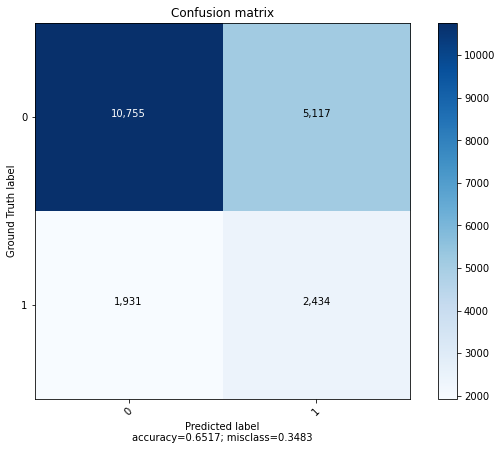

In [20]:
class_name = [0, 1]
plot_confusion_matrix(lg_predict_top3_test, y_test_top3, class_name, normalize=False)

## Ensemble model

### Soft Voting

In [21]:
#create a dictionary of our models
estimator = [("catboost", catboost_model), 
             ("lightGBM", lg_model)]

#create our voting classifier, inputting our models

vot_soft = VotingClassifier(estimators = estimator, voting ='soft') 
vot_soft.fit(X_train_std, y_train_top3)

yhat_train = vot_soft.predict(X_train_std)
yhat_test = vot_soft.predict(X_test_std)

[LightGBM] [Warning] feature_fraction is set=0.98412273666869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.98412273666869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=165
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.8585711947529121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8585711947529121


correct_pred_top3/total_actual_top3:  0.5709049255441008


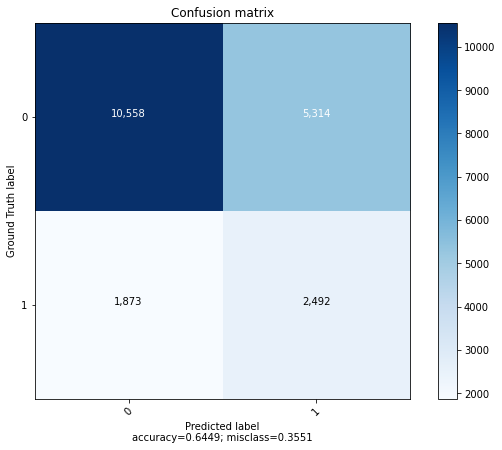

In [22]:
class_name = [0, 1]
plot_confusion_matrix(yhat_test, y_test_top3, class_name, normalize=False)

In [23]:
# Calculate accuracy
f1_score_train, true_pos_win_rate_train = calc_accuracy(y_train_top3, yhat_train)
f1_score_test, true_pos_win_rate_test = calc_accuracy(y_test_top3, yhat_test)

# Append values to accuracy dictionary
f1_scores["train"]["EN_SOFT"] = round(f1_score_train, 4)
true_pos_wining_rates["train"]["EN_SOFT"] = round(true_pos_win_rate_train, 4)
f1_scores["test"]["EN_SOFT"] = round(f1_score_test, 4)
true_pos_wining_rates["test"]["EN_SOFT"] = round(true_pos_win_rate_test, 4)

create_model_pickle(vot_soft, 'vot_soft.pkl')

print("f1_score:", f1_scores)
print("\n")
print("true positive wining rate:", true_pos_wining_rates)

F1 score: 0.77165
correct_pred_top3/total_actual_top3: 0.80320
F1 score: 0.67347
correct_pred_top3/total_actual_top3: 0.57090
Pickling the model into the file vot_soft.pkl
Finished pickling the model
f1_score: {'train': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.7652, 'lightGBM': 0.7772, 'EN_HARD': 0, 'EN_SOFT': 0.7716}, 'test': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.668, 'lightGBM': 0.6789, 'EN_HARD': 0, 'EN_SOFT': 0.6735}}


true positive wining rate: {'train': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.8142, 'lightGBM': 0.7922, 'EN_HARD': 0, 'EN_SOFT': 0.8032}, 'test': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.583, 'lightGBM': 0.5576, 'EN_HARD': 0, 'EN_SOFT': 0.5709}}


### Hard Voting

In [24]:
#create a dictionary of our models
estimator = [("catboost", catboost_model), 
             ("lightGBM", lg_model)]


#create our voting classifier, inputting our models
vot_hard = VotingClassifier(estimators = estimator, voting ='hard') 
vot_hard.fit(X_train_std, y_train_top3)

yhat_train = vot_hard.predict(X_train_std)
yhat_test = vot_hard.predict(X_test_std)


[LightGBM] [Warning] feature_fraction is set=0.98412273666869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.98412273666869
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=165
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=0.8585711947529121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8585711947529121


correct_pred_top3/total_actual_top3:  0.5562428407789233


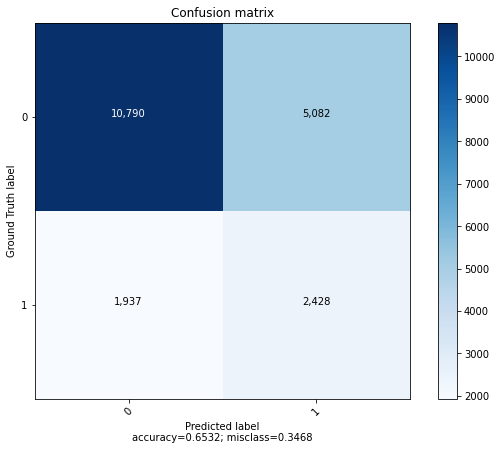

In [25]:
class_name = [0, 1]
plot_confusion_matrix(yhat_test, y_test_top3, class_name, normalize=False)

In [26]:
# Calculate accuracy
f1_score_train, true_pos_win_rate_train = calc_accuracy(y_train_top3, yhat_train)
f1_score_test, true_pos_win_rate_test = calc_accuracy(y_test_top3, yhat_test)

# Append values to accuracy dictionary
f1_scores["train"]["EN_HARD"] = round(f1_score_train, 4)
true_pos_wining_rates["train"]["EN_HARD"] = round(true_pos_win_rate_train, 4)
f1_scores["test"]["EN_HARD"] = round(f1_score_test, 4)
true_pos_wining_rates["test"]["EN_HARD"] = round(true_pos_win_rate_test, 4)

create_model_pickle(vot_hard, 'vot_hard.pkl')

print("f1_score:", f1_scores)
print("\n")
print("true positive wining rate:", true_pos_wining_rates)

F1 score: 0.77801
correct_pred_top3/total_actual_top3: 0.79066
F1 score: 0.68002
correct_pred_top3/total_actual_top3: 0.55624
Pickling the model into the file vot_hard.pkl
Finished pickling the model
f1_score: {'train': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.7652, 'lightGBM': 0.7772, 'EN_HARD': 0.778, 'EN_SOFT': 0.7716}, 'test': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.668, 'lightGBM': 0.6789, 'EN_HARD': 0.68, 'EN_SOFT': 0.6735}}


true positive wining rate: {'train': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.8142, 'lightGBM': 0.7922, 'EN_HARD': 0.7907, 'EN_SOFT': 0.8032}, 'test': {'logis_reg': 0, 'randomForest': 0, 'catboost': 0.583, 'lightGBM': 0.5576, 'EN_HARD': 0.5562, 'EN_SOFT': 0.5709}}


## Create f1_score.json and true_pos_wining_rates.json

In [27]:
with open('f1_scores.json', 'w') as fp:
    json.dump(f1_scores, fp)

with open('true_pos_wining_rates.json', 'w') as fp:
    json.dump(true_pos_wining_rates, fp)

# Report

In [28]:
d = {
    "true_pos_wining_rates-training": true_pos_wining_rates["train"],
    "F1-score-training": f1_scores["train"],
    "true_pos_wining_rates-testing": true_pos_wining_rates["test"],
    "F1-score-testing": f1_scores["test"]
}
algorithms_list = ["Logistic Regression", "Random Forest", "CatBoost", "LightGBM", "Hard Voting", "Soft Voting"]
df = pd.DataFrame(d).reset_index().drop(columns="index")
df.insert(0, "Algorithm", algorithms_list)
df

,Algorithm,true_pos_wining_rates-training,F1-score-training,true_pos_wining_rates-testing,F1-score-testing
0,Logistic Regression,0.0000,0.0000,0.0000,0.0000
1,Random Forest,0.0000,0.0000,0.0000,0.0000
2,CatBoost,0.8142,0.7652,0.5830,0.6680
3,LightGBM,0.7922,0.7772,0.5576,0.6789
4,Hard Voting,0.7907,0.7780,0.5562,0.6800
5,Soft Voting,0.8032,0.7716,0.5709,0.6735
